## Imports & Website Connection Handler Creation

In [8]:
from vision_transformer import VisionTransformer
from website_connection_handler import WebsiteConnectionHandler
from custom_dataset import CustomDataset
import torch
from torch.utils.data import DataLoader
from torchvision import transforms,utils
import torch.nn as nn
from helper_functions import imageShow, graphShow
from PIL import Image
import glob
import os

## Data Loading

In [9]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5))
])
batch_size = 32

dataset = CustomDataset(root_dir='/Users/wpqbswn/Desktop/Ofek/8200-learning/NadlanCaptchaNumbersClassification/Data', transform=transform)

trainDataset, valDataset, testDataset = dataset.split_dataset(trainSize=0.8, shuffle=True)

trainLoader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True)
valLoader = DataLoader(valDataset, batch_size=batch_size, shuffle=True)
testLoader = DataLoader(testDataset, batch_size=batch_size, shuffle=True)

classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

## Data Visualization

               8                6                2                0


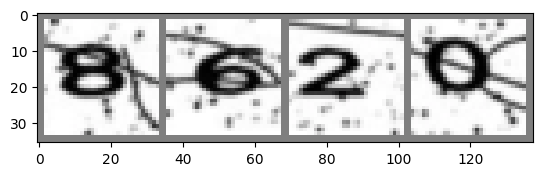

In [10]:
dataiter = iter(trainLoader)
images, labels = next(dataiter)
imageShow(utils.make_grid(images[:4]))
print(' '.join('%16s' % classes[int(labels[j])] for j in range(4)))

## Model Training

In [11]:
model = VisionTransformer(image_size=32, patch_size=8, num_classes=10, num_layers=2, num_heads=2, hidden_dim=128, 
                 mlp_dim=512, dropout=0.0, attention_dropout=0.0)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [12]:
def train_model(model, criterion, optimizer, num_epochs=5):
  for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch+1, num_epochs))
      print('-' * 10)

      for phase in ['train', 'val']:
          if phase == 'train':
              model.train()
              current_loader = trainLoader
              dataset_size = len(trainDataset)
          else:
              model.eval()
              current_loader = valLoader
              dataset_size = len(valDataset)
          
          running_loss = 0.0
          running_corrects = 0

          for _, (images, true_labels) in enumerate(current_loader):
            optimizer.zero_grad()
            MLP_scores = model(images)
            tensorTrueLabels = torch.tensor(tuple(int(el) for el in true_labels))
            loss = criterion(MLP_scores, torch.tensor(tensorTrueLabels))
            if phase == 'train':
              loss.backward()
              optimizer.step()
            predicted_labels = torch.argmax(MLP_scores, dim=1)
            running_loss += loss.item()
            running_corrects += torch.sum(torch.eq(predicted_labels, tensorTrueLabels), dim=0).item()
          
          epoch_loss = running_loss / dataset_size
          epoch_acc = running_corrects / dataset_size

          model.data_tracking_for_visualization[phase]['loss'].append(epoch_loss)
          model.data_tracking_for_visualization[phase]['acc'].append(epoch_acc)
            
          print('{} Loss: {:.4f}  |  Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))


In [13]:
train_model(model, criterion, optimizer, num_epochs=20)

Epoch 1/20
----------


/var/folders/2k/198b0h4941b0vjpw9dns0rbw0000gn/T/ipykernel_10835/2082935292.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(MLP_scores, torch.tensor(tensorTrueLabels))


train Loss: 0.0312  |  Acc: 0.6558
val Loss: 0.0142  |  Acc: 0.8630
Epoch 2/20
----------
train Loss: 0.0085  |  Acc: 0.9161
val Loss: 0.0065  |  Acc: 0.9400
Epoch 3/20
----------
train Loss: 0.0041  |  Acc: 0.9587
val Loss: 0.0077  |  Acc: 0.9200
Epoch 4/20
----------
train Loss: 0.0027  |  Acc: 0.9726
val Loss: 0.0020  |  Acc: 0.9810
Epoch 5/20
----------
train Loss: 0.0021  |  Acc: 0.9784
val Loss: 0.0019  |  Acc: 0.9810
Epoch 6/20
----------
train Loss: 0.0020  |  Acc: 0.9804
val Loss: 0.0022  |  Acc: 0.9840
Epoch 7/20
----------
train Loss: 0.0019  |  Acc: 0.9824
val Loss: 0.0034  |  Acc: 0.9630
Epoch 8/20
----------
train Loss: 0.0018  |  Acc: 0.9808
val Loss: 0.0019  |  Acc: 0.9870
Epoch 9/20
----------
train Loss: 0.0008  |  Acc: 0.9932
val Loss: 0.0007  |  Acc: 0.9910
Epoch 10/20
----------
train Loss: 0.0020  |  Acc: 0.9792
val Loss: 0.0024  |  Acc: 0.9780
Epoch 11/20
----------
train Loss: 0.0010  |  Acc: 0.9905
val Loss: 0.0016  |  Acc: 0.9830
Epoch 12/20
----------
train L

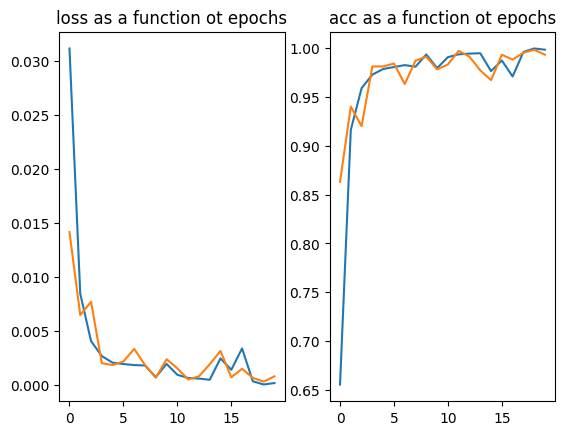

In [14]:
graphShow(model)

## Model Evaluation

Train accuracy: 0.9870
True Labels:
         6          5          0          3
Predicted Labels:
         6          5          0          3


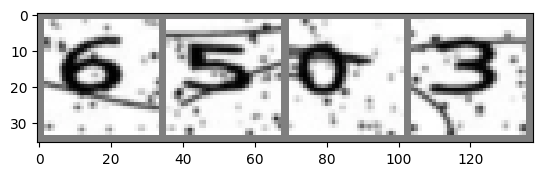

In [15]:
model.eval()
dataset_size = len(testDataset)

running_corrects = 0.0

for images, true_labels in testLoader:
  optimizer.zero_grad()
  MLP_scores = model(images)
  predicted_labels = torch.argmax(MLP_scores, dim=1)
  tensorTrueLabels = torch.tensor(tuple(int(el) for el in true_labels))
  running_corrects += torch.sum(torch.eq(predicted_labels, tensorTrueLabels), dim=0).item()

accuracy = running_corrects / dataset_size

imageShow(utils.make_grid(images[:4]))

print(f'Train accuracy: {accuracy:.4f}')


print('True Labels:')
print(' '.join('%10s' % classes[tensorTrueLabels[j]]  for j in range(4)))
print('Predicted Labels:')
print(' '.join('%10s' % classes[predicted_labels[j]]  for j in range(4)))

## Captcha Hacking 

In [16]:
wch = WebsiteConnectionHandler()
wch.SaveImageForCaptchaHack()
finalNumberArray = [0,0,0,0]
for fileName in glob.iglob('/Users/wpqbswn/Desktop/Ofek/8200-learning/NadlanCaptchaNumbersClassification/single_image/*'):
    imagePath = fileName
    with Image.open(imagePath) as image:
        image = transform(image)
        image = torch.unsqueeze(image[:3,:,:], dim=0)
        MLP_scores = model(image)
        predicted_label = torch.argmax(MLP_scores, dim=1).item()
        digitLocation = fileName[90]
        finalNumberArray[int(digitLocation) - 1] = str(predicted_label)
    os.remove(imagePath)
finalNumber = ''.join(finalNumberArray)
wch.enterNumberToCaptcha(finalNumber)